In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [64]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scipystats

from utils.psth import get_shuffled, get_spike_counts
from utils.neurosuite import get_unit_names_sorted
from utils.behavior import get_idxs_as_periods

In [117]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

#session = '013608_ppcSIT_2025-01-06_13-20-52'  # PPC
session = '013608_ppcSIT_2025-01-14_10-20-14'  # HPC
#session = '013608_ppcSIT_2025-01-15_14-56-18'  # HPC
#session = '013608_ppcSIT_2025-01-16_09-49-21'  # PPC
#session = '013608_ppcSIT_2025-01-20_09-38-20'  # HPC
#session = '013608_ppcSIT_2025-01-21_08-50-02'  # Thalamus
#session = '013608_ppcSIT_2025-01-22_12-59-00'  # PPC
#session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC

animal      = session.split('_')[0]
meta_file   = os.path.join(source, animal, session, 'meta.h5')
units_file  = os.path.join(source, animal, session, 'units.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')

In [136]:
# reading events and spiking data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

spike_times = {}
inst_rates = {}
with h5py.File(units_file, 'r') as f:
    unit_ids = get_unit_names_sorted([name for name in f])
    for unit_name in f:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])
        inst_rates[unit_name] = np.array(f[unit_name]['inst_rate'])

In [119]:
# MRL
MRL_mx = np.zeros([len(unit_ids), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_ids):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [139]:
# mean firing rate
FR_mx = np.zeros([len(unit_ids), 4])  # mean rate, median ISI, mean instantaneous rate, STD
for i, unit_id in enumerate(unit_ids):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    mean_inst_rate = inst_rates[unit_id].mean()
    std_inst_rate  = inst_rates[unit_id].std()
    
    FR_mx[i] = np.array([mean_rate, robust_rate, mean_inst_rate, std_inst_rate])

In [121]:
# exclude some?
# for unit in ['1-137', '2-394', '3-157', '4-282', '4-326', '4-425']:
#     spike_times.pop(unit)

MFR_min = 0.5

idxs_mfr_min = np.where(FR_mx[:, 0] > MFR_min)[0]
print(f"{len(idxs_mfr_min)} out of {len(unit_ids)} units > 0.5Hz firing rate")

#unit_ids = [unit_ids[x] for x in idxs_mfr_min]

156 out of 213 units > 0.5Hz firing rate


In [122]:
x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]
speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]

idxs_sta_ev = np.where(speed_ev < 0.04)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_di1_ev = np.where(sound_events[:, 1] == 3)[0]
idxs_di2_ev = np.where(sound_events[:, 1] == 4)[0]

## Construct locations

In [123]:
# all matrices for all diff types of visits and stays
# every matrix has columns: start event idx, end event idx, X pos, Y pos
visit_matrices = {}  

In [124]:
# 1. successful target stays
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
tgt_succ_xy = np.zeros([len(tgt_mx_succ), 4])

for i, tgt_rec in enumerate(tgt_mx[tgt_mx[:, 4] == 1]):
    x_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 1]
    y_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 2]
    
    tgt_succ_xy[i] = [tgt_rec[0], tgt_rec[1], x_pos.mean(), y_pos.mean()]
    
visit_matrices['TGT_scores'] = tgt_succ_xy

In [125]:
# 2. just stops for a certain period (no matter where but stationary)
min_dur = 12  # in sounds events, 4 events per second
conds = ['BGR_long_stays', 'SIL_long_stays']

for i, idxs_condition in enumerate([idxs_bgr_ev, idxs_sil_ev]):
    periods_sta_ev = get_idxs_as_periods(np.intersect1d(idxs_sta_ev, idxs_condition))
    periods_filt = periods_sta_ev[np.where(np.diff(periods_sta_ev, axis=1) > min_dur)[0]]
    
    long_stays_xy = np.zeros([len(periods_filt), 4])
    for j, ls_rec in enumerate(periods_filt):
        idx_tl_s = int(sound_events[ls_rec[0]][2])
        idx_tl_e = int(sound_events[ls_rec[1]][2])
        x_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 1]
        y_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 2]

        long_stays_xy[j] = [ls_rec[0], ls_rec[1], x_pos.mean(), y_pos.mean()]
        
    visit_matrices[conds[i]] = long_stays_xy

In [208]:
# 3. target visits (no matter run or stationary, important is where)
r_max = 0.05  # in meters
min_ev_per_visit = 8  # 4 is one second

#idxs_sil_sta = np.intersect1d(idxs_sil_ev, idxs_sta_ev)
#idxs_bgr_sta = np.intersect1d(idxs_bgr_ev, idxs_sta_ev)

idxs_visits = {'SIL': [], 'BGR': []}  # visits as ranges of indices to sound events
titles = ['SIL', 'BGR']
for i, tgt_xy in enumerate(visit_matrices['TGT_scores']):
    idxs_around_ev = np.where( (x_pos_ev - tgt_xy[2])**2 + (y_pos_ev - tgt_xy[3])**2 < r_max**2 )[0]
    idxs_around_sil_ev = np.intersect1d(idxs_around_ev, idxs_sil_ev)
    idxs_around_bgr_ev = np.intersect1d(idxs_around_ev, idxs_bgr_ev)

    for j, idxs_events in enumerate([idxs_around_sil_ev, idxs_around_bgr_ev]):
        idxs_coll = list(idxs_visits[titles[j]])
        idxs_sil_as_per = get_idxs_as_periods(idxs_events)
        if len(idxs_sil_as_per.shape) == 1:
            idxs_sil_as_per = np.array([idxs_sil_as_per])
        idxs_sil_as_per = idxs_sil_as_per[np.where(np.diff(idxs_sil_as_per, axis=1) > min_ev_per_visit - 2)[0]]
        for per in idxs_sil_as_per:
            idx_tl_s = int(sound_events[per[0]][2])
            idx_tl_e = int(sound_events[per[1]][2])
            x_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 1]
            y_pos = tl[np.arange(idx_tl_s, idx_tl_e)][:, 2]
            idxs_coll.append([int(per[0]), int(per[1]), x_pos.mean(), y_pos.mean(), i])

        idxs_visits[titles[j]] = np.array(idxs_coll)
        
visit_matrices['BGR_visits'] = idxs_visits['BGR']
visit_matrices['SIL_visits'] = idxs_visits['SIL']

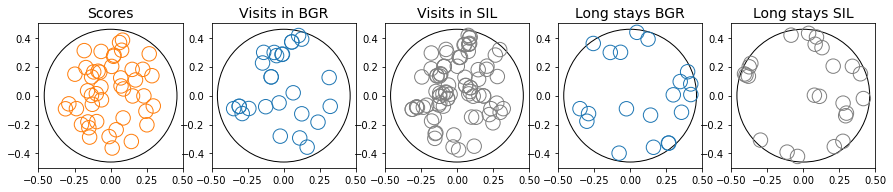

In [209]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

mx_types = ['TGT_scores', 'BGR_visits', 'SIL_visits', 'BGR_long_stays', 'SIL_long_stays']
colors = ['tab:orange', 'tab:blue', 'grey', 'tab:blue', 'grey']
titles = ['Scores', 'Visits in BGR', 'Visits in SIL', 'Long stays BGR', 'Long stays SIL']

for i, mx_type in enumerate(mx_types):
    mx = visit_matrices[mx_type]
    
    ax = axes[i]
    ax.scatter(mx[:, 0], mx[:, 1], color=colors[i], alpha=0.92)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_aspect('equal')
    
    # arena
    arena = plt.Circle((0, 0), 0.46, color='black', fill=False)
    ax.add_patch(arena)
    
    # visits - circles
    r_max = 0.05  # in meters
    for rec in mx:
        visit = plt.Circle((rec[2], rec[3]), r_max, color=colors[i], fill=False)
        ax.add_patch(visit)
        
    ax.set_title(titles[i], fontsize=14)
    if i < 0:
        ax.set_yticks([])

## Representation of a pulse between scores

In [210]:
hw, bc = 0.25, 51
#score_mx = visit_matrices['TGT_scores']
score_mx = visit_matrices['BGR_visits']
score_matrices = []

idxs_unit_nan = []
for i, score_rec in enumerate(score_mx):
    idxs_ev = np.arange(score_rec[0], score_rec[1]).astype(np.int32)
    times_ev = sound_events[idxs_ev][:, 0]

    psth_mx = np.zeros([len(unit_ids), int(bc/2)])
    for j, unit_name in enumerate(unit_ids):
        bins, psth = get_spike_counts(spike_times[unit_name], times_ev, hw=hw, bin_count=bc)

        # scaling ?! TODO!!
        #scaled = (psth - np.min(psth)) / (np.max(psth) - np.min(psth))  # MinMax 
        #scaled = scipystats.zscore(psth)  # z-score
        
        psth = psth[int(bc/2):]
        
        # try to z-score
        psth_z = (psth - FR_mx[j][2]) / FR_mx[j][3]
        
        if np.isnan(psth_z).any():
            idxs_unit_nan.append(j)
            
        psth_mx[j] = psth_z
        
    score_matrices.append(psth_mx.copy())

In [211]:
# fig = plt.figure(figsize=(15, 30))

# for i, mx in enumerate(score_matrices):
#     ax = fig.add_subplot(4, 15, i+1)
#     ax.imshow(mx)

In [212]:
dist_mx = np.zeros([len(score_matrices), len(score_matrices)])
time_mx = np.zeros([len(score_matrices), len(score_matrices)])
corr_mx = np.zeros([len(score_matrices), len(score_matrices)])
dotp_mx = np.zeros([len(score_matrices), len(score_matrices)])

for i, psth_mx_1 in enumerate(score_matrices):
    for j, psth_mx_2 in enumerate(score_matrices):
        dist_mx[i][j] = np.sqrt( (score_mx[i][2] - score_mx[j][2])**2 + (score_mx[i][3] - score_mx[j][3])**2 )
        time_mx[i][j] = np.abs(score_mx[i][0] - score_mx[j][0]) / 4  # in seconds
        
        v1 = psth_mx_1.flatten()
        v2 = psth_mx_2.flatten()
        corr_mx[i][j] = np.corrcoef(v1, v2)[0][1]
        dotp_mx[i][j] = np.dot(v1, v2)

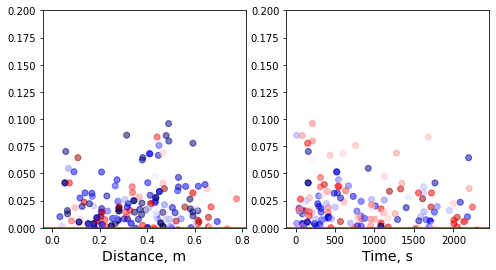

In [213]:
corr_mx_f = corr_mx.flatten()
dotp_mx_f = dotp_mx.flatten()
dist_mx_f = dist_mx.flatten()
time_mx_f = time_mx.flatten()
idxs_filt = np.where(corr_mx_f < 0.9)[0]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.scatter(dist_mx_f, corr_mx_f, c=time_mx_f, cmap='seismic', alpha=0.3)
ax.axhline(0, color='red')
ax.set_xlabel('Distance, m', fontsize=14)
ax.set_ylim(0., 0.2)
d_slope, d_intercept, _, d_p_value, _ = scipystats.linregress(dist_mx_f[idxs_filt], corr_mx_f[idxs_filt])

ax = axes[1]
ax.scatter(time_mx_f, corr_mx_f, c=dist_mx_f, cmap='seismic', alpha=0.3)
ax.axhline(0, color='red')
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylim(0., 0.2)

t_slope, t_intercept, _, t_p_value, _ = scipystats.linregress(time_mx_f[idxs_filt], dotp_mx_f[idxs_filt])

In [214]:
d_slope, d_p_value, t_slope, t_p_value 

(-0.027839601234310108,
 0.0003121355429142667,
 -0.31749043042759795,
 0.0011041791929143276)

In [160]:
len(score_matrices)

46